 # MIDI Model Playground

 An exploratory notebook for playing with model architecture ideas.

In [1]:
import pathlib
import sys
import numpy as np
import pypianoroll
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils, layers, Model, optimizers, Sequential

sys.path.append("..")
from musiclearn import config

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:
# Picking one song from MusicNet dataset
midi_dir = pathlib.Path(config.MUSICNET_MIDI_DIR)
mid_2494 = midi_dir / "Beethoven" / "2494_qt11_1.mid"
multitrack = pypianoroll.read(mid_2494, resolution=24)


/csslab-localdata/csslab-si/jack_working_dir/tutorial/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[<AxesSubplot:xlabel='time (beat)', ylabel='Violin1\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Violin2\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Viola\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Cello\n\npitch'>]

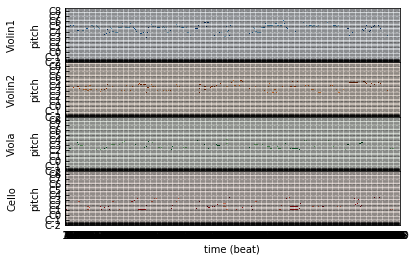

In [3]:
multitrack.plot()


 ## Training data representation

 Because an entire song is too long music is generally composed in bars or
 multi-bar phrases, we plan to read MIDI files and segment them into phrases,
 one training example per phrase.

In [4]:
def get_num_beats(multitrack, resolution):
    return len(multitrack.downbeat) // resolution


def get_bar_bounds(bar_index, num_bars, beats_per_bar, resolution):
    start = bar_index * resolution
    end = start + (num_bars * beats_per_bar) * resolution
    return (start, end)



In [5]:
def bars(multitrack, start_index, num_bars, beats_per_bar, resolution):
    start, end = get_bar_bounds(start_index, num_bars, beats_per_bar, resolution)
    tracks = []
    for track in multitrack.tracks:
        tracks.append(
            pypianoroll.Track(
                name=track.name,
                program=track.program,
                pianoroll=track[start:end],
            )
        )
    return pypianoroll.Multitrack(tracks=tracks, resolution=resolution)



 Plot a bar of Beethoven:

[<AxesSubplot:xlabel='time (beat)', ylabel='Violin1\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Violin2\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Viola\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='Cello\n\npitch'>]

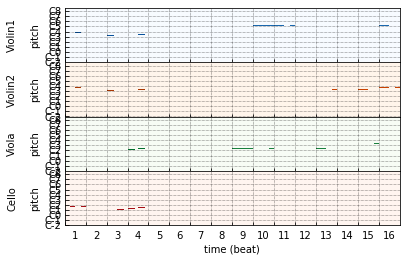

In [6]:
resolution = 24
first_bar = bars(multitrack, 0, 4, 4, resolution)
first_bar.plot()

In [7]:
viola_track = first_bar.tracks[2]



 ## Pianoroll sequence autoencoder model

 Testing out training a simple autoencoder model on a single track.

In [8]:
# Prepare training examples from the binarized cello track
resolution = 24
beats_per_bar = 4
bars_per_phrase = 2
total_bars = get_num_beats(multitrack, resolution) // beats_per_bar
total_phrases = total_bars // bars_per_phrase
print("Total phrases= ", total_phrases)

Total phrases=  76


In [9]:
viola_clips = [
    bars(
        multitrack,
        i * bars_per_phrase,
        bars_per_phrase,
        beats_per_bar,
        resolution,
    )
    .tracks[2]
    .binarize()
    .pianoroll.astype(int)
    for i in range(total_phrases)
]
np_viola = np.array(viola_clips)


In [10]:
np_viola

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 


 The viola only plays notes 48-70, notes outside this range are all zeroes
 We can trim the note space to reduce dimensionality and avoid the model trying
 to fit notes outside the viola's range.

In [11]:
np_viola.sum(axis=(0, 1))


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 2084,  468,  268,  412,  248,  959,  260,
        828, 1786,  169, 1700,  460,  476, 1568,   81,  368,   88,  344,
        580,    0,  160,   33,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [12]:
np_viola

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [13]:
np_viola = np_viola[:, :, 48:70]
np_viola.sum(axis=(0, 1))


array([2084,  468,  268,  412,  248,  959,  260,  828, 1786,  169, 1700,
        460,  476, 1568,   81,  368,   88,  344,  580,    0,  160,   33])

In [ ]:
# make the features ordinal
# np_viola = np.argmax(np_viola, axis=2).astype(float)
# np_viola = np_viola.reshape(np_viola.shape[0], np_viola.shape[1], 1)


In [14]:
np_viola


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [15]:
np_viola.shape

(76, 192, 22)

In [16]:
n_timesteps = np_viola.shape[1]
n_features = np_viola.shape[2]
shape = (n_timesteps, n_features)
print(shape)


(192, 22)


In [17]:
opt = optimizers.Adam(learning_rate=0.0001)
act = "tanh"
model = Sequential()
model.add(
    layers.LSTM(
        64,
        activation="tanh",
        input_shape=(n_timesteps, n_features),
        return_sequences=True,
        
    )
)
model.add(layers.LSTM(128, activation=act, return_sequences=True))
model.add(layers.LSTM(128, activation=act, return_sequences=True))
model.add(layers.LSTM(128, activation=act, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(n_features, activation="softmax")))
model.compile(
    optimizer=opt,
    # loss="categorical_crossentropy",
    loss="kullback_leibler_divergence",
    metrics=["categorical_accuracy"],
)
# utils.plot_model(model, show_shapes=True)


In [18]:
history = model.fit(np_viola, np_viola, epochs=500)


Epoch 1/500
3/3 [==============================] - 3s 21ms/step - loss: 2.7768 - categorical_accuracy: 0.0471
Epoch 2/500
3/3 [==============================] - 0s 23ms/step - loss: 2.8661 - categorical_accuracy: 0.1898
Epoch 3/500
3/3 [==============================] - 0s 25ms/step - loss: 2.8546 - categorical_accuracy: 0.3758
Epoch 4/500
3/3 [==============================] - 0s 22ms/step - loss: 2.7830 - categorical_accuracy: 0.4438
Epoch 5/500
3/3 [==============================] - 0s 26ms/step - loss: 2.7553 - categorical_accuracy: 0.4430
Epoch 6/500
3/3 [==============================] - 0s 28ms/step - loss: 2.7789 - categorical_accuracy: 0.4711
Epoch 7/500
3/3 [==============================] - 0s 24ms/step - loss: 2.7476 - categorical_accuracy: 0.4639
Epoch 8/500
3/3 [==============================] - 0s 24ms/step - loss: 2.7204 - categorical_accuracy: 0.4439
Epoch 9/500
3/3 [==============================] - 0s 28ms/step - loss: 2.6817 - categorical_accuracy: 0.4418
Epoch 10/5

3/3 [==============================] - 0s 35ms/step - loss: 1.3093 - categorical_accuracy: 0.4747
Epoch 75/500
3/3 [==============================] - 0s 19ms/step - loss: 1.2904 - categorical_accuracy: 0.4530
Epoch 76/500
3/3 [==============================] - 0s 25ms/step - loss: 1.2635 - categorical_accuracy: 0.5057
Epoch 77/500
3/3 [==============================] - 0s 23ms/step - loss: 1.2466 - categorical_accuracy: 0.4976
Epoch 78/500
3/3 [==============================] - 0s 25ms/step - loss: 1.2647 - categorical_accuracy: 0.4768
Epoch 79/500
3/3 [==============================] - 0s 31ms/step - loss: 1.2363 - categorical_accuracy: 0.4784
Epoch 80/500
3/3 [==============================] - 0s 47ms/step - loss: 1.2066 - categorical_accuracy: 0.5115
Epoch 81/500
3/3 [==============================] - 0s 24ms/step - loss: 1.2323 - categorical_accuracy: 0.5049
Epoch 82/500
3/3 [==============================] - 0s 34ms/step - loss: 1.2101 - categorical_accuracy: 0.4829
Epoch 83/500
3

3/3 [==============================] - 0s 34ms/step - loss: 0.8389 - categorical_accuracy: 0.6079
Epoch 148/500
3/3 [==============================] - 0s 38ms/step - loss: 0.8277 - categorical_accuracy: 0.6236
Epoch 149/500
3/3 [==============================] - 0s 20ms/step - loss: 0.7895 - categorical_accuracy: 0.6212
Epoch 150/500
3/3 [==============================] - 0s 20ms/step - loss: 0.8164 - categorical_accuracy: 0.6013
Epoch 151/500
3/3 [==============================] - 0s 22ms/step - loss: 0.8406 - categorical_accuracy: 0.5903
Epoch 152/500
3/3 [==============================] - 0s 22ms/step - loss: 0.8245 - categorical_accuracy: 0.6278
Epoch 153/500
3/3 [==============================] - 0s 26ms/step - loss: 0.8285 - categorical_accuracy: 0.6202
Epoch 154/500
3/3 [==============================] - 0s 42ms/step - loss: 0.8227 - categorical_accuracy: 0.6511
Epoch 155/500
3/3 [==============================] - 0s 44ms/step - loss: 0.8184 - categorical_accuracy: 0.6227
Epoch 

3/3 [==============================] - 0s 24ms/step - loss: 0.6930 - categorical_accuracy: 0.6642
Epoch 221/500
3/3 [==============================] - 0s 22ms/step - loss: 0.6956 - categorical_accuracy: 0.6598
Epoch 222/500
3/3 [==============================] - 0s 27ms/step - loss: 0.6775 - categorical_accuracy: 0.6381
Epoch 223/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6696 - categorical_accuracy: 0.6531
Epoch 224/500
3/3 [==============================] - 0s 49ms/step - loss: 0.6632 - categorical_accuracy: 0.6597
Epoch 225/500
3/3 [==============================] - 0s 37ms/step - loss: 0.6318 - categorical_accuracy: 0.6764
Epoch 226/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6639 - categorical_accuracy: 0.6763
Epoch 227/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6420 - categorical_accuracy: 0.6724
Epoch 228/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6348 - categorical_accuracy: 0.6752
Epoch 

3/3 [==============================] - 0s 20ms/step - loss: 0.5771 - categorical_accuracy: 0.6872
Epoch 294/500
3/3 [==============================] - 0s 19ms/step - loss: 0.5447 - categorical_accuracy: 0.6996
Epoch 295/500
3/3 [==============================] - 0s 70ms/step - loss: 0.5707 - categorical_accuracy: 0.6989
Epoch 296/500
3/3 [==============================] - 0s 22ms/step - loss: 0.5797 - categorical_accuracy: 0.7047
Epoch 297/500
3/3 [==============================] - 0s 24ms/step - loss: 0.5702 - categorical_accuracy: 0.6726
Epoch 298/500
3/3 [==============================] - 0s 24ms/step - loss: 0.5792 - categorical_accuracy: 0.6810
Epoch 299/500
3/3 [==============================] - 0s 22ms/step - loss: 0.5613 - categorical_accuracy: 0.6863
Epoch 300/500
3/3 [==============================] - 0s 23ms/step - loss: 0.5547 - categorical_accuracy: 0.6888
Epoch 301/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5480 - categorical_accuracy: 0.7039
Epoch 

3/3 [==============================] - 0s 39ms/step - loss: 0.5246 - categorical_accuracy: 0.6937
Epoch 367/500
3/3 [==============================] - 0s 31ms/step - loss: 0.5178 - categorical_accuracy: 0.7190
Epoch 368/500
3/3 [==============================] - 0s 19ms/step - loss: 0.4957 - categorical_accuracy: 0.7342
Epoch 369/500
3/3 [==============================] - 0s 38ms/step - loss: 0.4924 - categorical_accuracy: 0.6936
Epoch 370/500
3/3 [==============================] - 0s 47ms/step - loss: 0.4955 - categorical_accuracy: 0.7138
Epoch 371/500
3/3 [==============================] - 0s 33ms/step - loss: 0.5143 - categorical_accuracy: 0.7022
Epoch 372/500
3/3 [==============================] - 0s 31ms/step - loss: 0.5137 - categorical_accuracy: 0.7007
Epoch 373/500
3/3 [==============================] - 0s 53ms/step - loss: 0.5031 - categorical_accuracy: 0.7069
Epoch 374/500
3/3 [==============================] - 0s 20ms/step - loss: 0.5158 - categorical_accuracy: 0.6823
Epoch 

3/3 [==============================] - 0s 26ms/step - loss: 0.4708 - categorical_accuracy: 0.7229
Epoch 440/500
3/3 [==============================] - 0s 20ms/step - loss: 0.4597 - categorical_accuracy: 0.7053
Epoch 441/500
3/3 [==============================] - 0s 19ms/step - loss: 0.4513 - categorical_accuracy: 0.7120
Epoch 442/500
3/3 [==============================] - 0s 24ms/step - loss: 0.4498 - categorical_accuracy: 0.7246
Epoch 443/500
3/3 [==============================] - 0s 22ms/step - loss: 0.4686 - categorical_accuracy: 0.7232
Epoch 444/500
3/3 [==============================] - 0s 19ms/step - loss: 0.4690 - categorical_accuracy: 0.7257
Epoch 445/500
3/3 [==============================] - 0s 25ms/step - loss: 0.4469 - categorical_accuracy: 0.7283
Epoch 446/500
3/3 [==============================] - 0s 25ms/step - loss: 0.4622 - categorical_accuracy: 0.7301
Epoch 447/500
3/3 [==============================] - 0s 23ms/step - loss: 0.4571 - categorical_accuracy: 0.7422
Epoch 

In [ ]:
def lstm_with_attention(learning_rate = 0.001):
    opt = optimizers.Adam(learning_rate = learning_rate)
    model = Sequential([
        layers.Bidirectional(
            layers.LSTM(512, activation='tanh', return_sequences=True), 
            input_shape=(n_timesteps, n_features)
        ),
        layers.Attention(),
        layers.LSTM(512, activation='tanh', return_sequences=True),
        layers.TimeDistributed(layers.Dense(n_features, activation="softmax"))
    ])
    
    model.compile(
        optimizer=opt,
        loss="kullback_leibler_divergence",
        metrics=["categorical_accuracy"]
    )
    
    return model

In [ ]:
model = lstm_with_attention()
history = model.fit(np_viola, np_viola, epochs=100)

In [ ]:
yhat = model.predict(np_viola)
yhat[0, :, 0]
preds = (yhat > 0.5).astype(int)

In [ ]:
np.argmax(preds[0, :, :], axis=1)

In [ ]:
np.argmax(np_viola[0, :, :], axis=1)
